In [1]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import mlflow

In [2]:
# mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment('exp-2205')

<Experiment: artifact_location='mlflow-artifacts:/3', creation_time=1747929293961, experiment_id='3', last_update_time=1747929293961, lifecycle_stage='active', name='exp-2205', tags={}>

In [3]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str)

In [4]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

np.sqrt(mean_squared_error(y_train, y_pred))

np.float64(9.838799799829628)

/tmp/ipykernel_10244/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_10244/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


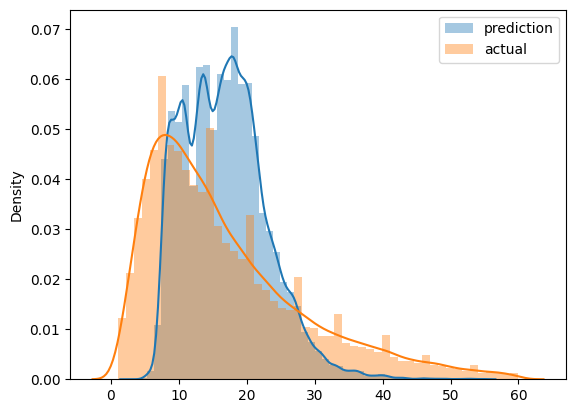

In [5]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

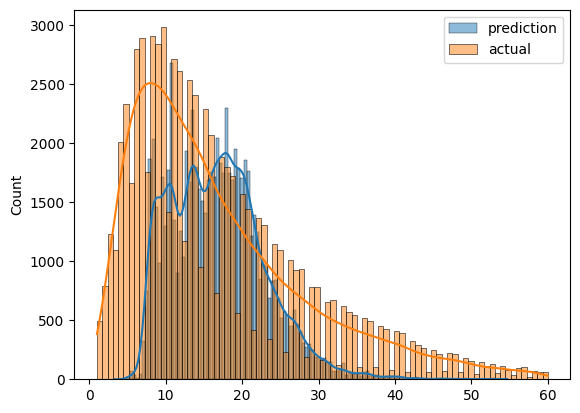

In [6]:
sns.histplot(y_pred, label='prediction', kde=True)
sns.histplot(y_train, label='actual', kde=True)
plt.legend()
plt.show()

In [7]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [8]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [9]:
len(df_train), len(df_val)

(73908, 61921)

In [10]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [11]:
categorical = ['PU_DO'] 
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [12]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [13]:
X_val.shape

(61921, 13221)

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

np.sqrt(mean_squared_error(y_val, y_pred))

np.float64(7.758715200888857)

In [15]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [16]:
with mlflow.start_run():

    mlflow.set_tag('developer', 'waseem')
    mlflow.log_param('train-data', 'green_tripdata_2021-01.parquet')
    mlflow.log_param('valid-data', 'green_tripdata_2021-02.parquet')

    alpha = 0.01
    mlflow.log_param('alpha', alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))    
    mlflow.log_metric('RMSE', rmse)

    mlflow.log_artifact(local_path='models/lin_reg.bin', artifact_path='models_pickle')

🏃 View run illustrious-koi-550 at: http://localhost:5000/#/experiments/3/runs/2106572b58714d4b8c8a357dcaf5a1f7
🧪 View experiment at: http://localhost:5000/#/experiments/3


## Module 2

In [17]:
import xgboost as xgb
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# from hyperopt.pyll import scope

In [18]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [19]:
# def objective(params):
#     with mlflow.start_run():
#         mlflow.set_tag('model','xgboost')
#         mlflow.log_params(params)
#         booster = xgb.train(
#             params=params,
#             dtrain=train,
#             num_boost_round=1000,
#             evals=[(valid, 'validation')],
#             early_stopping_rounds=50
#         )
#         y_pred = booster.predict(valid)
#         rmse = np.sqrt(mean_squared_error(y_val, y_pred))
#         mlflow.log_metric('rmse',rmse)
#     return {'loss': rmse, 'status': STATUS_OK}

In [20]:
# search_space = {
#     # 'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
#     'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
#     'learning_rate': hp.loguniform('learning_rate', -3, 0),
#     'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
#     'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
#     'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
#     'objective': 'reg:linear',
#     'seed': 42
# }

In [21]:
# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=Trials()
# )

In [22]:
import mlflow.xgboost
import xgboost as xgb

with mlflow.start_run():

    best_params = {
        'learning_rate':0.461341010616988,
        'max_depth':16,
        'min_child_weight':0.6663060298762274,
        'objective':'reg:squarederror',
        'reg_alpha':0.14566888843218836,
        'reg_lambda':0.01467369193843644,
        'seed':1
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
            params=best_params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
    
    with open('models/preprocessor.b', 'wb') as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact(local_path='models/preprocessor.b', artifact_path='preprocessor')

    
    y_pred = booster.predict(valid)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mlflow.log_metric('rmse', rmse)

    mlflow.xgboost.log_model(booster, artifact_path='models_mlflow')
    

[0]	validation-rmse:8.85623
[1]	validation-rmse:7.51756
[2]	validation-rmse:7.02019
[3]	validation-rmse:6.82555
[4]	validation-rmse:6.74859
[5]	validation-rmse:6.70793
[6]	validation-rmse:6.68853
[7]	validation-rmse:6.67815
[8]	validation-rmse:6.67031
[9]	validation-rmse:6.66350
[10]	validation-rmse:6.66098
[11]	validation-rmse:6.65723
[12]	validation-rmse:6.65341
[13]	validation-rmse:6.64778
[14]	validation-rmse:6.64620
[15]	validation-rmse:6.64279
[16]	validation-rmse:6.64061
[17]	validation-rmse:6.63852
[18]	validation-rmse:6.63582
[19]	validation-rmse:6.63447
[20]	validation-rmse:6.63326
[21]	validation-rmse:6.62817
[22]	validation-rmse:6.62558
[23]	validation-rmse:6.62294
[24]	validation-rmse:6.61947
[25]	validation-rmse:6.61552
[26]	validation-rmse:6.61410
[27]	validation-rmse:6.61377
[28]	validation-rmse:6.61274
[29]	validation-rmse:6.61109
[30]	validation-rmse:6.61044
[31]	validation-rmse:6.60848
[32]	validation-rmse:6.60479
[33]	validation-rmse:6.60288
[34]	validation-rmse:6.6

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:40:59] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/23 16:41:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run puzzled-colt-956 at: http://localhost:5000/#/experiments/3/runs/7f5154d9e5ca43f4bf779b015d20ecdb
🧪 View experiment at: http://localhost:5000/#/experiments/3


In [23]:
import mlflow
logged_model = 'runs:/7f5154d9e5ca43f4bf779b015d20ecdb/models_mlflow'

loaded_model = mlflow.pyfunc.load_model(logged_model)

In [27]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 7f5154d9e5ca43f4bf779b015d20ecdb

In [28]:
import mlflow.xgboost


xgboost_model = mlflow.xgboost.load_model(logged_model)

In [31]:
xgboost_model

In [35]:
xgboost_model